<a href="https://colab.research.google.com/github/mahima-c/AutoEncoder/blob/main/conv%2Bvae_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# deep autoencoder
# stack autoencoder
# convolution auto encoder
import tensorflow as tf

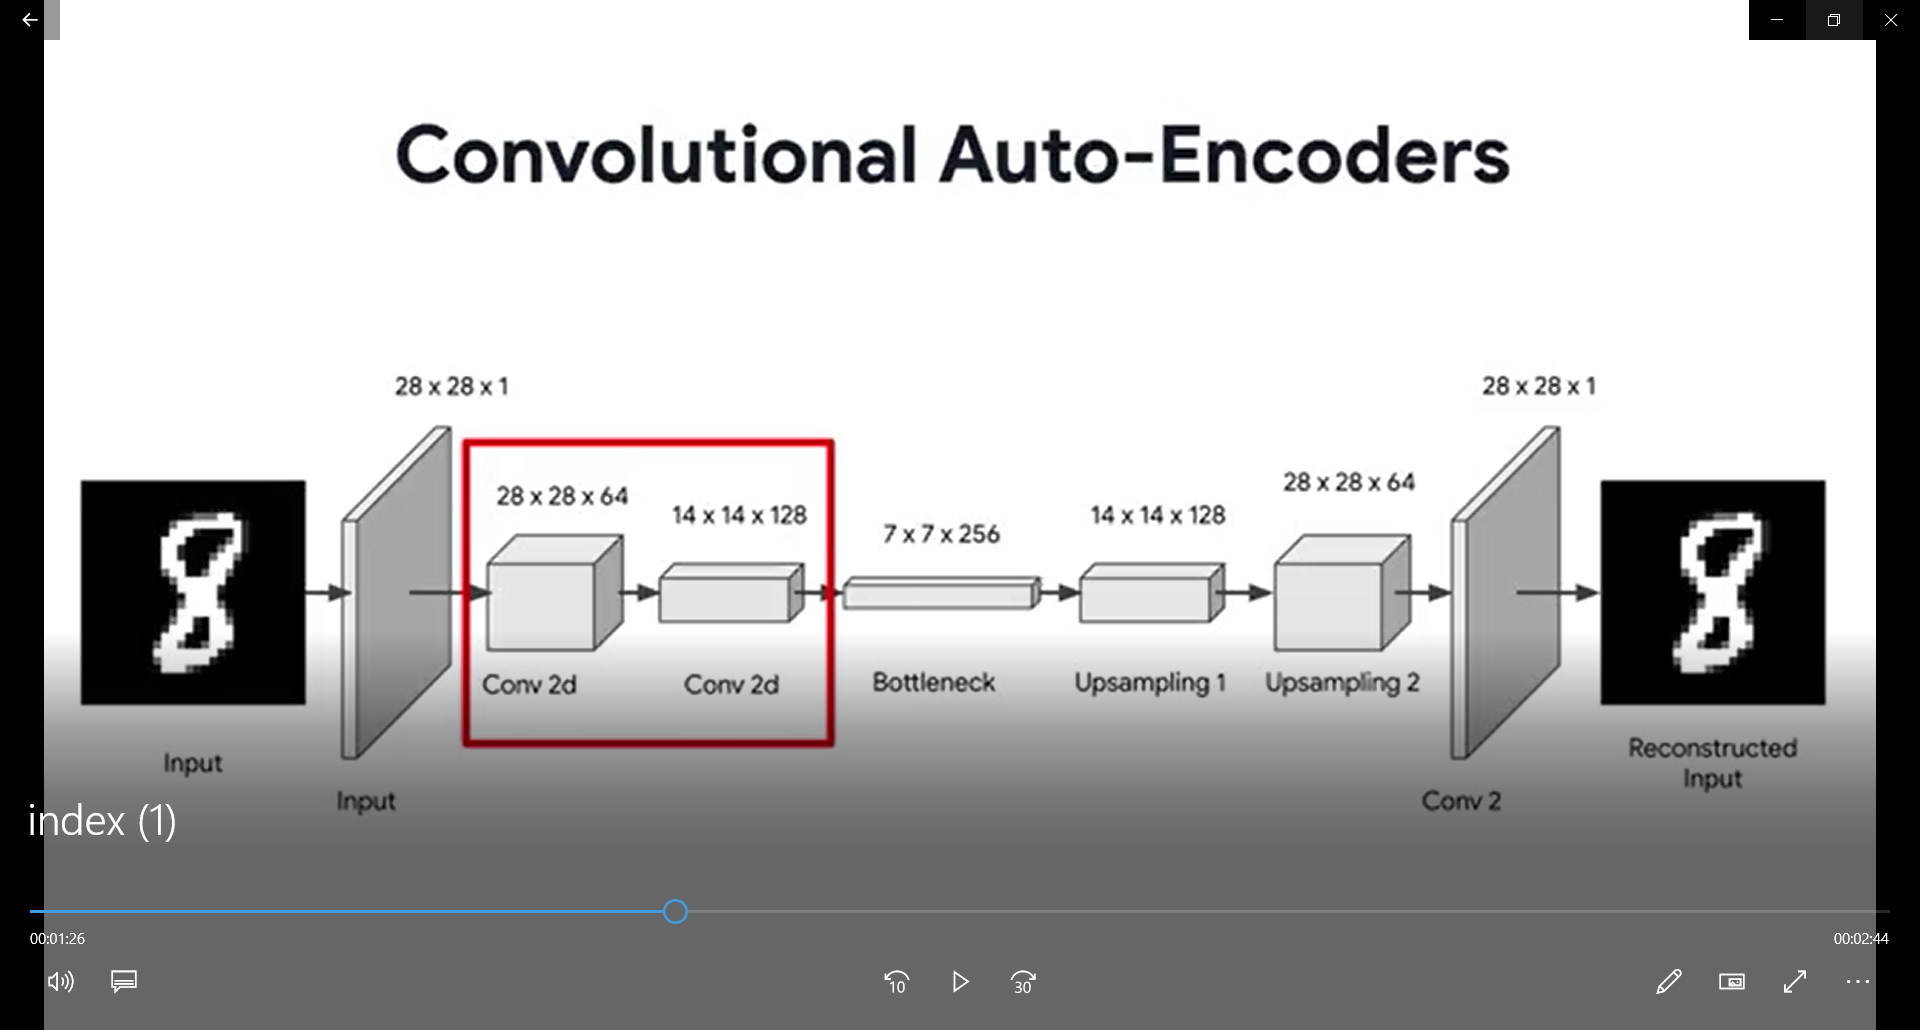

In [ ]:
def encoder(inputs):
  conv_1=tf.keras.layers.Conv2D(filters=64,kernal_size=(3,3),activation='relu',padding='same')(inputs)
  max_pool_1=tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)
  conv_2=tf.keras.layers.Conv2D(filters=128,kernal_size=(3,3),activation='relu',padding='same')(max_pool_1)
  max_pool_2=tf.keras.ayers.MaxPooling2D(pool_size=(2,2))(conv_2)
  return max_pool_2

In [ ]:
def bottle_neck(inputs):
  bottel_neck=tf.keras.layers.Conv2D(filters=256,kernal_size=(3,3),activation='relu',padding='same')(inputs)
  # this layer only for visualization
  encoder_visualization=tf.keras.layers.Conv2D(filters=1,kernal_size=(3,3),activation='sigmoid',padding='same')(bottel_neck)
  return bottel_neck,encoder_visualization

In [2]:
def decoder(inputs):
  conv_1=tf.keras.layers.Conv2D(filters=128,kernal_size=(3,3),activation='relu',padding='same')(inputs)
  upsample_1=tf.keras.layers.UpSampling2D(pool_size=(2,2))(conv_1)
  conv_2=tf.keras.layers.Conv2D(filters=64,kernal_size=(3,3),activation='relu',padding='same')(upsample_1)
  upsample_2=tf.keras.ayers.UpSampling2D(pool_size=(2,2))(conv_2)
  conv_3=tf.keras.layers.Conv2D(filters=1,kernal_size=(3,3),activation='sigmoid',padding='same')(upsample_2)

  return conv_3


In [ ]:
def convolutional_autoencoder():
  inputs=tf.keras.layers.Input(shape=(28,28,1,))
  encoder_output=encoder(inputs)
  bottleneck_output,encoder_visualization=bottle_neck(encoder_output)
  decoder_output=decoder(bottleneck_output)
  model=tf.keras.Model(inputs=inputs,outputs=decoder_output)
  encoder_model=tf.keras.Model(inputs=inputs,output=encoder_visualization)
  return model,encoder_model

In [ ]:
def map_image_with_noise(image,label):
  noise_factor=0.5
  image=tf.cast(image,dtype=tf.float32)
  image=image/255.0
  factor=noise_factor*tf.range.normal(shape=image.shape)
  image_noisy=image+factor
  image_noisy=tf.clib_by_value(image_noisy,0.0,1.0)
  return image_noisy,image

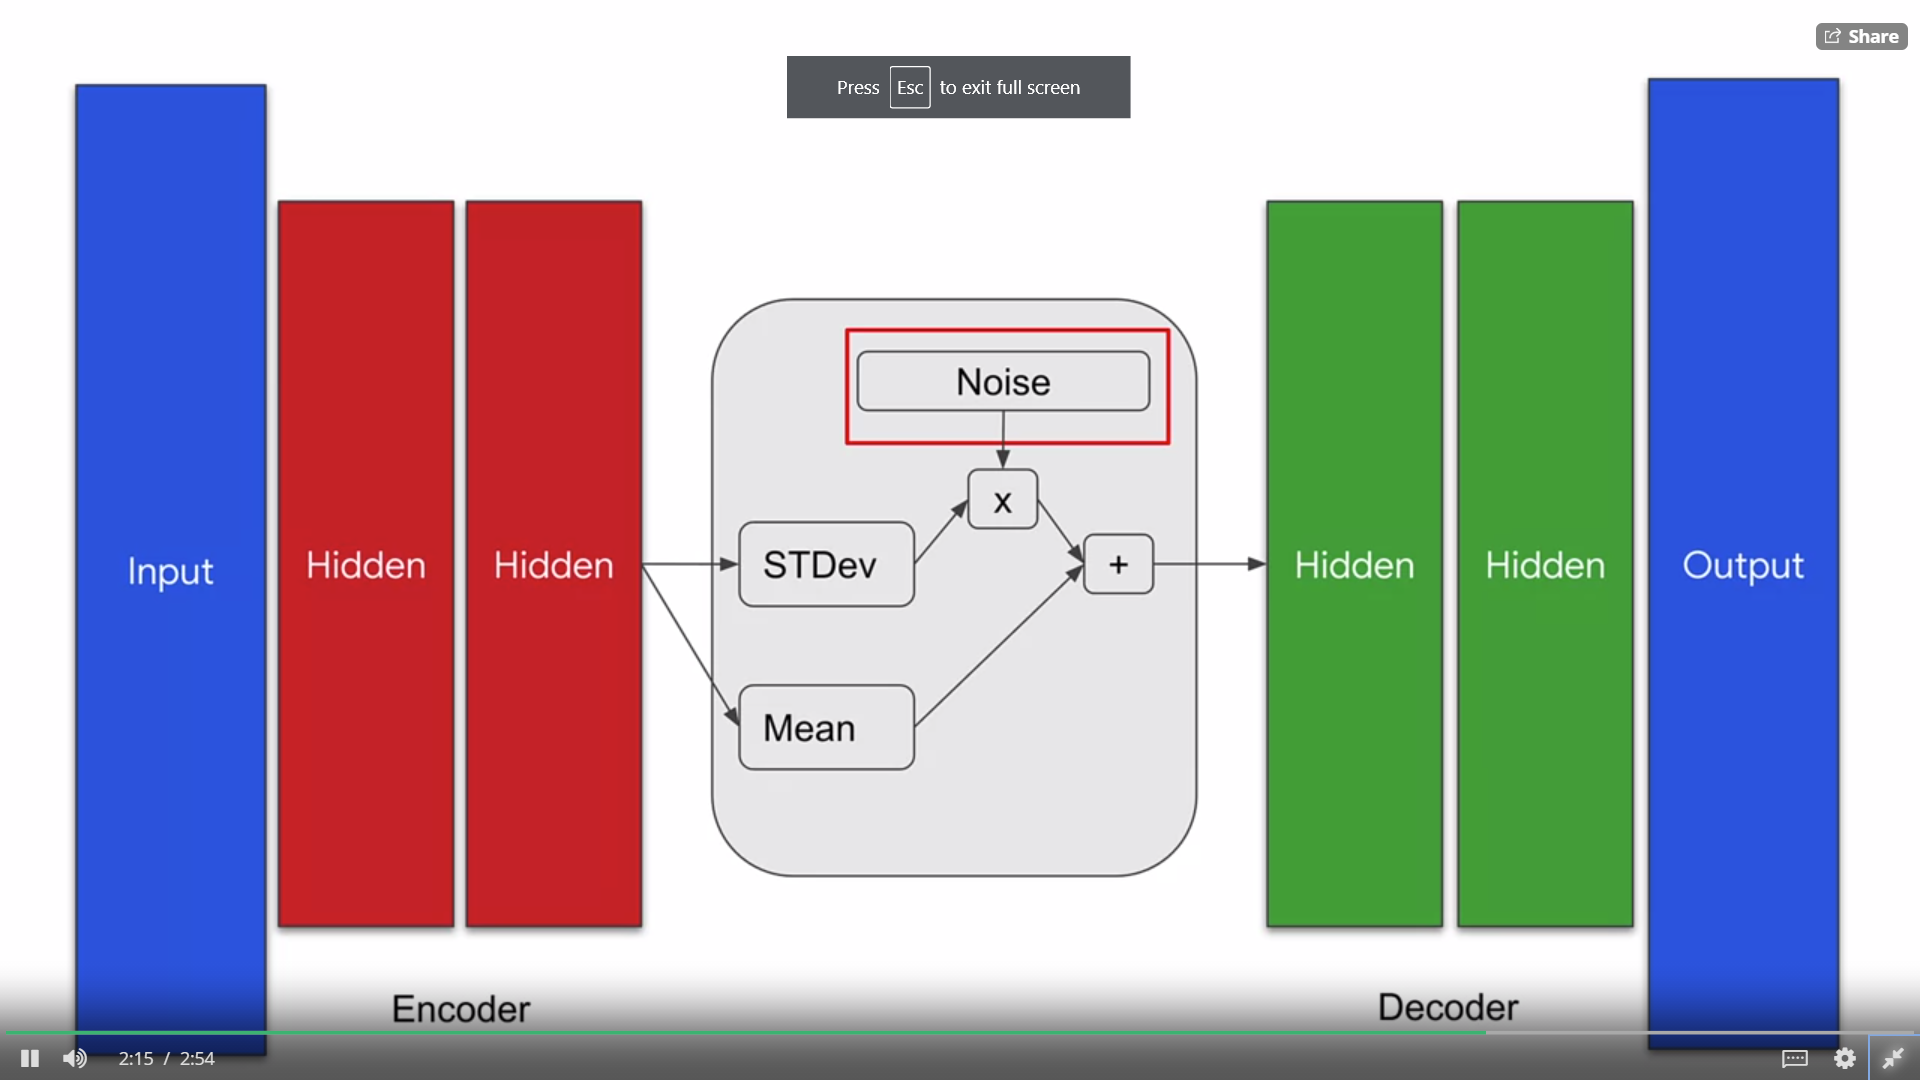

In [ ]:
# variational autoencoder is like it genrate completly new data

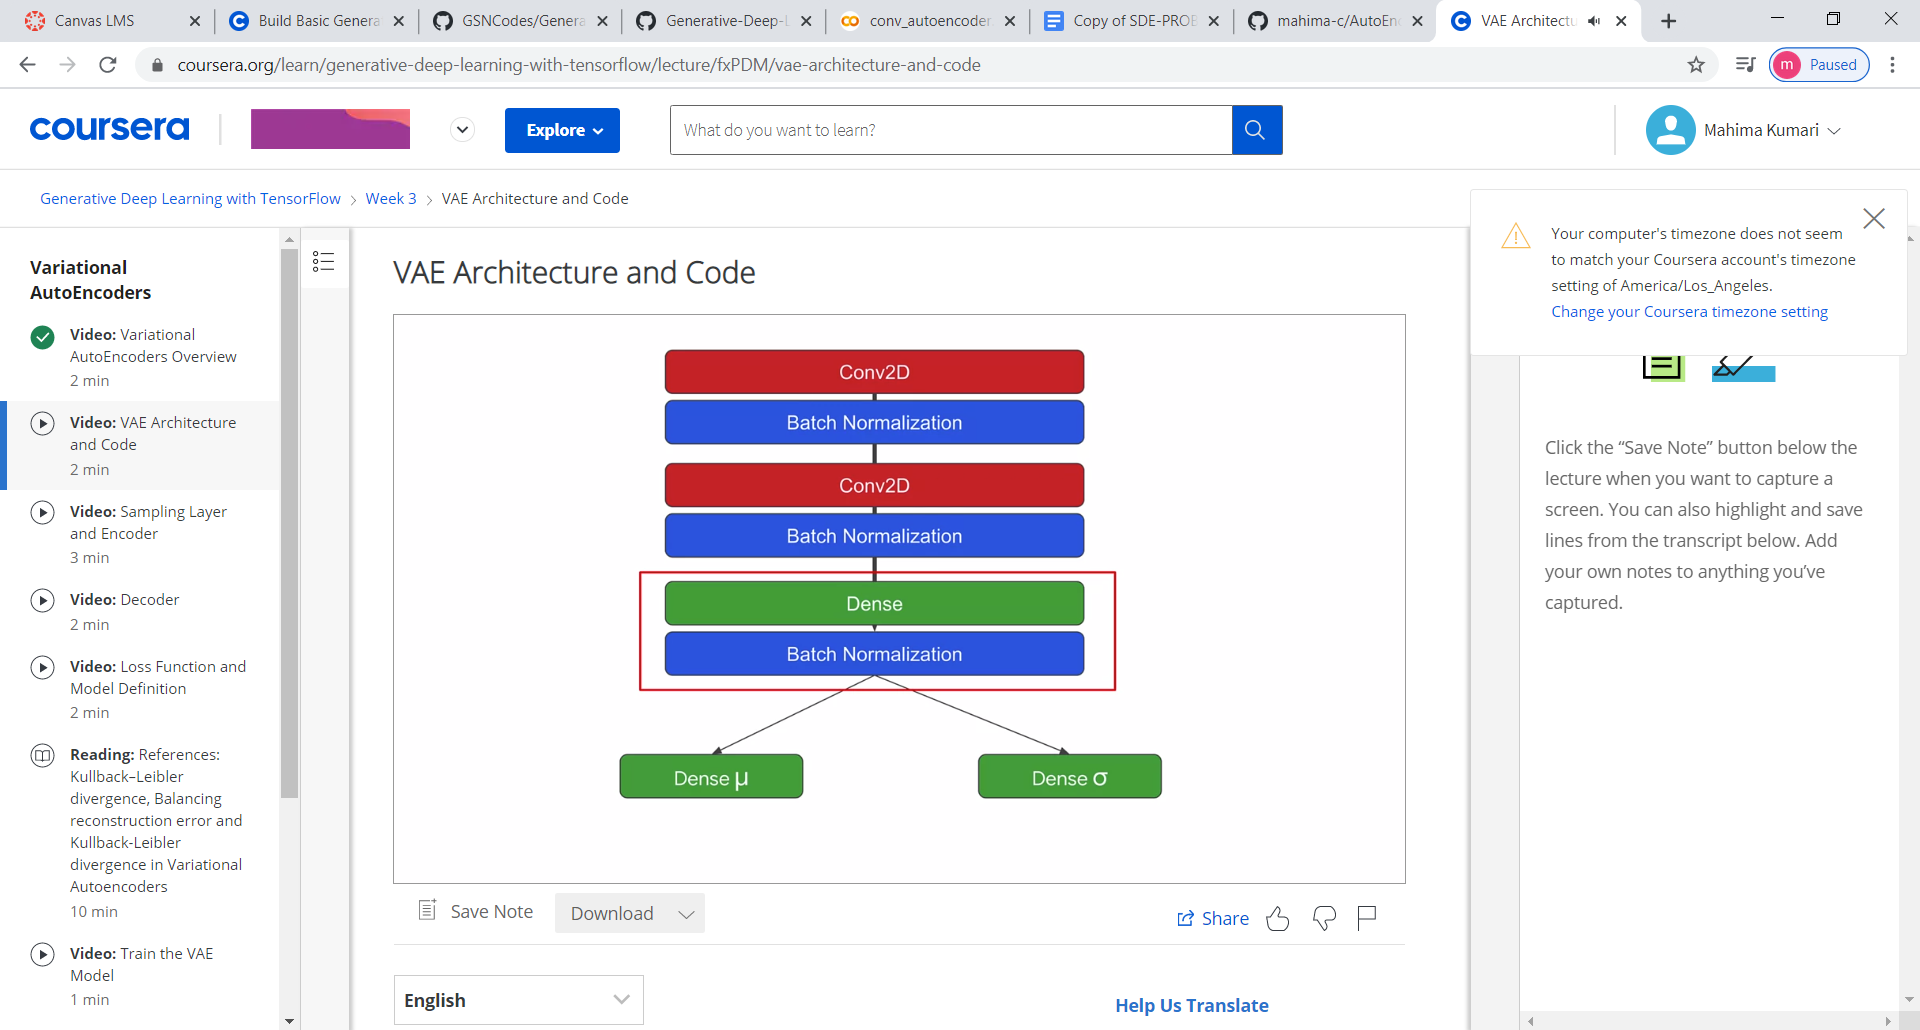

In [3]:
def encoder_layers(inputs,altent_dim):
    x=tf.keras.layers.Conv2D(filters=32,kernal_size=(3,3),strides=2,activation='relu',padding='same',name="encode_conv1")(inputs)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Conv2D(filters=64,kernal_size=(3,3),strides=2,activation='relu',padding='same',name="encode_conv2")(x)
    batch_2=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Flatten(name="encode_flatten")(batch_2)
    x=tf.keras.layers.Dense(20,activation='relu',name="encode_dense")(x)
    x=tf.keras.layers.BatchNormalization()(x)

    mu=tf.keras.layers.Dense(latent_dim,name='latent_mu')(x)
    sigma=tf.keras.layers.Dense(latent_dim,name='latent_sigma')(x)
    return mu,sigma,batch_2.shape



class Sampling(tf.keras.layers.Layer):
  def call(self,inputs):
    mu,sigma=inputs
    batch=tf.shape(mu)[0]
    dim=tf.shape(mu)[1]
    epsilon=tf.keras.backend.random_normal(shape=(batch,dim))
    return mu*tf.exp(0.5*sigma)*epsilon

def encoder_model(LATENT_DIM,input_shape):
  inputs=tf.keras.layers.Input(shape=input_shape)    
  mu,sigma,conv_shape=encoder_layers(inputs,latent_dim=LATENT_DIM)
  z=Sampling()((mu,sigma))
  model=tf.keras.Model(inputs,outputs=[mu,sigma,z])
  return model,conv_shape

def decoder_layers(inputs,conv_shape):
  units=conv_shape[1]*conv_shape[2]*conv_shape[3]
  x=tf.keras.layers.Dense(units,activation='relu',name="decode_dense1")(inputs)
  x=tf.keras.layers.BatchNormalization()(x)

  x=tf.keras.layers.Reshape((conv_shape[1],conv_shape[2],conv_shape[3]),name="decode_reshape")(x)
  x=tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,strides=2,activation='relu',padding='same',name="decode_conv2d_2")(x)
  x=tf.keras.layers.BatchNormalization()(x)

  x=tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=3,strides=2,activation='relu',padding='same',name="decode_conv2d_3")(x)
  x=tf.keras.layers.BatchNormalization()(x)

  x=tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=3,strides=2,activation='relu',padding='same',name="decode_final")(x)

  return x

def decoder_model(latent_dim,conv_shape):
  inputs=tf.keras.layers.Input(shape=(latent_dim,))
  outputs=decoder_layers(inputs,conv_shape)
  model=tf.keras.Model(inputs,outputs)
  return model  

def kl_reconstruction_loss(inputs,outputs,mu,sigma):
  kl_loss=1+sigma-tf.squaue(mu)-tf.math.exp(sigma)
  return tf.reduce_mean(kl_loss)* -0.5

def vae_model(encoder,decoder,input_shape):
  inputs=tf.keras.layers.Input(shape=input_shape)
  mu=encoder(inputs)[0]
  sigma=encoder(inputs)[1]
  z=encoder(inputs)[2]
  reconstructed=decoder(z)
  model=tf.keras.Model(inputs=inputs,outputs=reconstructed)
  loss=kl_reconstruction_loss(inputs,z,mu,sigma)
  model.add_loass(loss)
  return model 

In [4]:
# training
for epoch in range(epochs):
  for step,s_batch_train in enumerate(x_train_batch):
    with tf.GradiendTape() as tape:
      reconstructed=vae(x_batch_train)
      flattened_inputs=tf.reshape(x_batch_train,shape=[-1])
      flattened_outputs=tf.reshape(reconstructed,shape=[-1])
      loss=bce_loss(flattened_inputs,flattened_outputs)*784
      loss+=sum(vae.losses)

    grads=tape.gradient(loss,vae.trainable_weights)
    oprimizer.apply_gradient(zip(grads,vae.trainable_weights))   


NameError: ignored